Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

## 1. Importing Skin Cancer Data

### Importing all the important libraries

In [96]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [97]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [115]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_Assignment/Train")
data_dir_test = pathlib.Path('CNN_Assignment/Test')

In [116]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [117]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [118]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size,                    
    image_size=(img_height,img_width), 
    label_mode='categorical',
    seed=123,subset="training",
    validation_split=0.2)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [119]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size,                    
    image_size=(img_height,img_width), 
    label_mode='categorical',
    seed=123,subset="validation",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [120]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

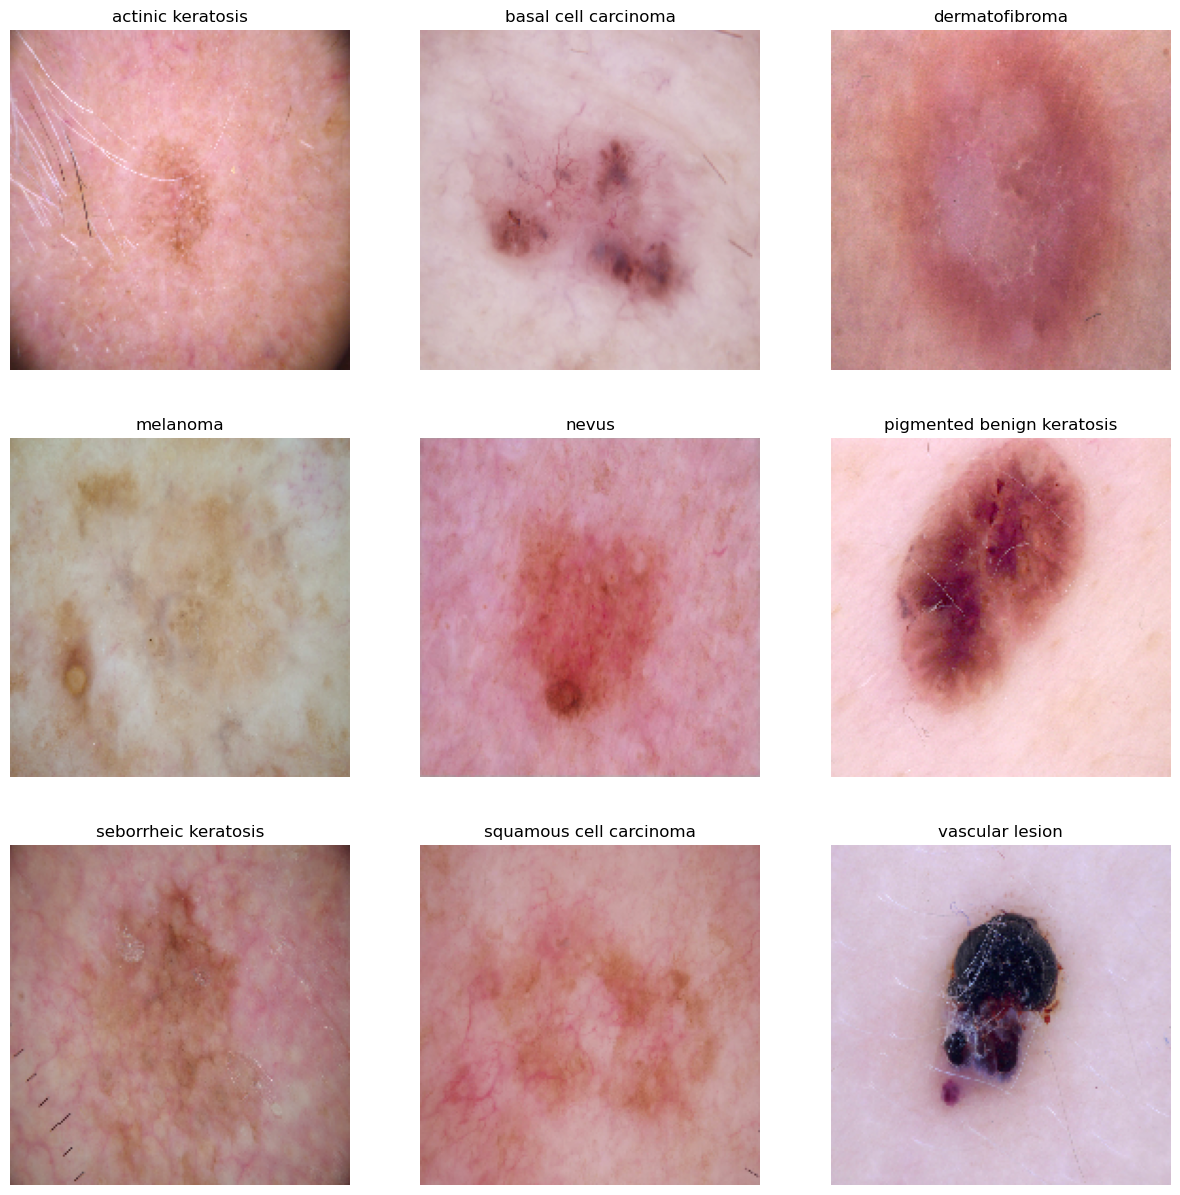

In [187]:
files_path_dict = {}

for c in train_ds.class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in train_ds.class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [122]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1

In [123]:
import keras
from keras import layers

In [124]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [125]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [126]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [127]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 555ms/step - accuracy: 0.2081 - loss: 2.5883 - val_accuracy: 0.2931 - val_loss: 1.9731
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.3493 - loss: 1.7832 - val_accuracy: 0.3826 - val_loss: 1.6805
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.4027 - loss: 1.6419 - val_accuracy: 0.4541 - val_loss: 1.5637
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.4501 - loss: 1.5300 - val_accuracy: 0.4765 - val_loss: 1.5006
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 572ms/step - accuracy: 0.5052 - loss: 1.4019 - val_accuracy: 0.5011 - val_loss: 1.4461
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5137 - loss: 1.3630 - val_accuracy: 0.4989 - val_loss: 1.5089
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 562ms/step - accuracy: 0.4701 - loss: 1.4455 - val_accuracy: 0.5190 - val_loss: 1.3988
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 568ms/step - accuracy: 0.5517 - loss: 1.2860 - val_accurac

### Visualizing training results

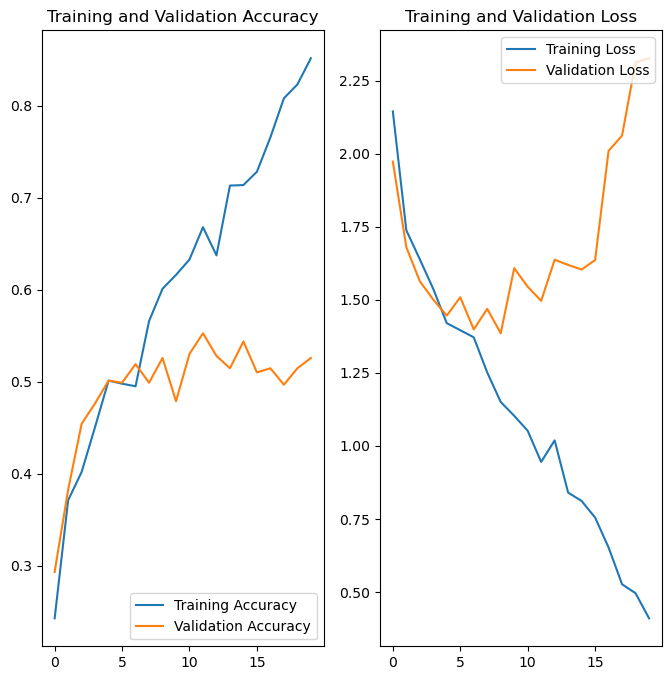

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation : 
- The model here is overfitting.
- There is a tred which shows the difference in the training and validation accuracy 
- Validation accuracy is below par i.e around 50%

### Model 2

In [129]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-04-10 15:47:29.732010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


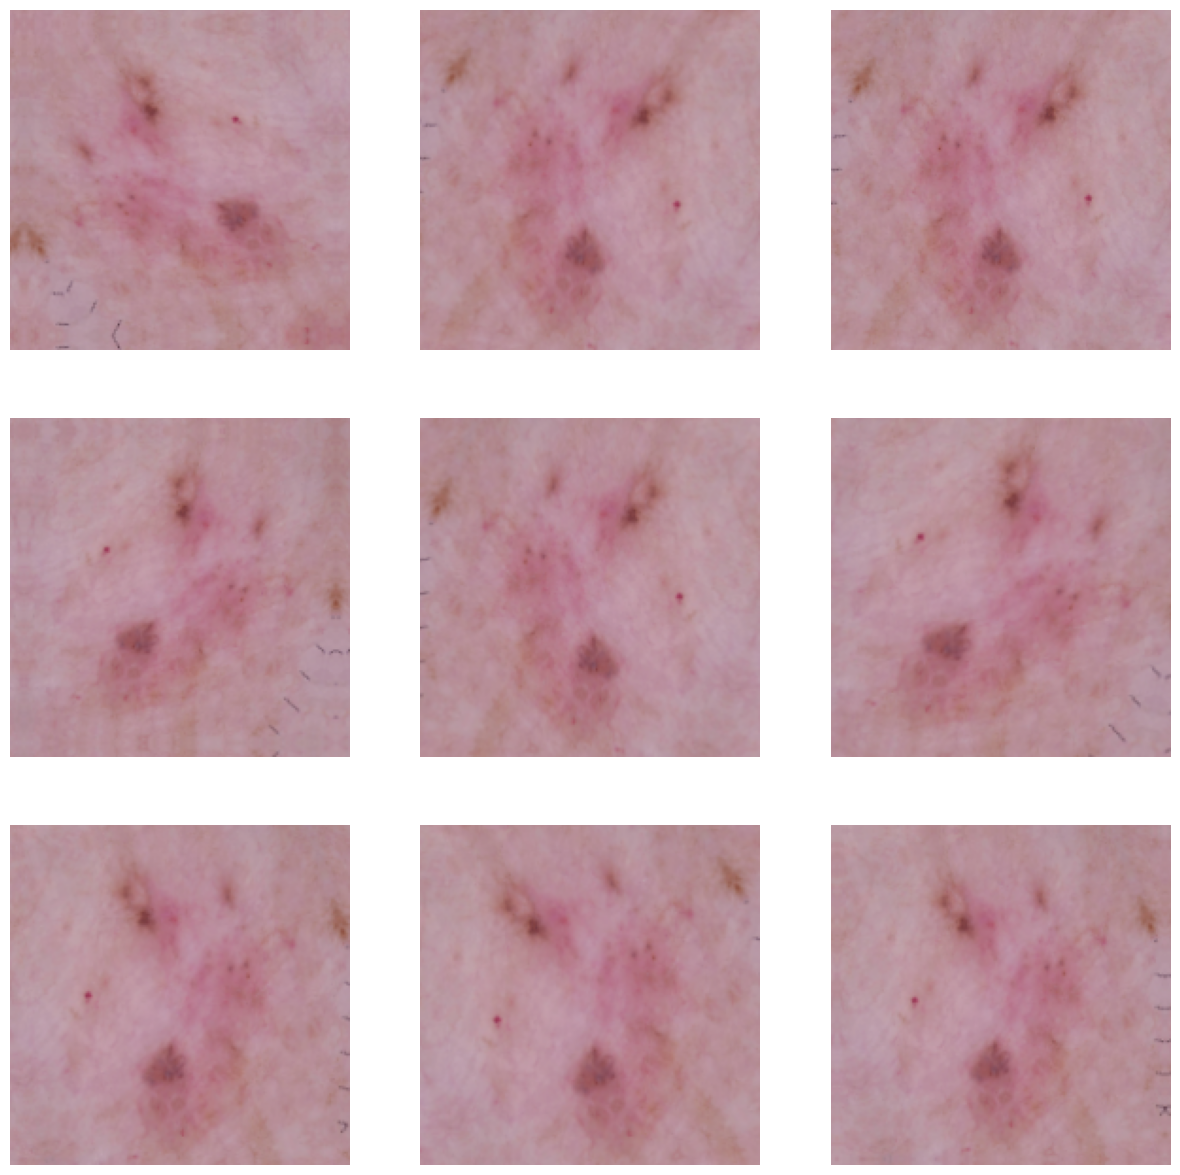

In [130]:
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [131]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([data_augmentation, layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [132]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [133]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [134]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.2062 - loss: 2.3501
Epoch 1: val_accuracy improved from -inf to 0.37360, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.2070 - loss: 2.3448 - val_accuracy: 0.3736 - val_loss: 1.7712
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.3758 - loss: 1.7201
Epoch 2: val_accuracy improved from 0.37360 to 0.45638, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 577ms/step - accuracy: 0.3760 - loss: 1.7199 - val_accuracy: 0.4564 - val_loss: 1.6387
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.4519 - loss: 1.5704
Epoch 3: val_accuracy improved from 0.45638 to 0.51902, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 588ms/step - accuracy: 0.4517 - loss: 1.5706 - val_accuracy: 0.5190 - val_loss: 1.4861
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4615 - loss: 1.5568
Epoch 4: val_accuracy improved from 0.51902 to 0.5391

### Visualizing the results

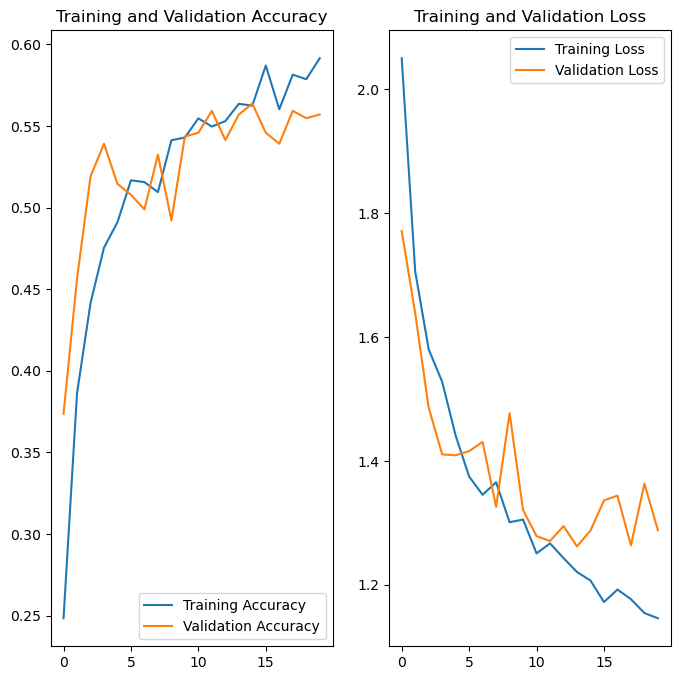

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- Overfitting is reduced and the accuracy for training and validation are closer

####  Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [191]:
def class_distribution_count(directory,subpath=""):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(str(directory)).iterdir():
        if path.is_dir():  
            count.append(len([name for name in os.listdir(str(path)+subpath)
                               if os.path.isfile(os.path.join(str(path)+subpath, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(str(directory))
                    if os.path.isdir(os.path.join(str(directory), name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Total Images'])

df = class_distribution_count(data_dir_train)
df

,Class,Total Images
0,melanoma,439
1,pigmented benign keratosis,463
2,nevus,358
3,basal cell carcinoma,377
4,actinic keratosis,115
5,squamous cell carcinoma,182
6,vascular lesion,140
7,seborrheic keratosis,78
8,dermatofibroma,96


<Axes: xlabel='Total Images', ylabel='Class'>

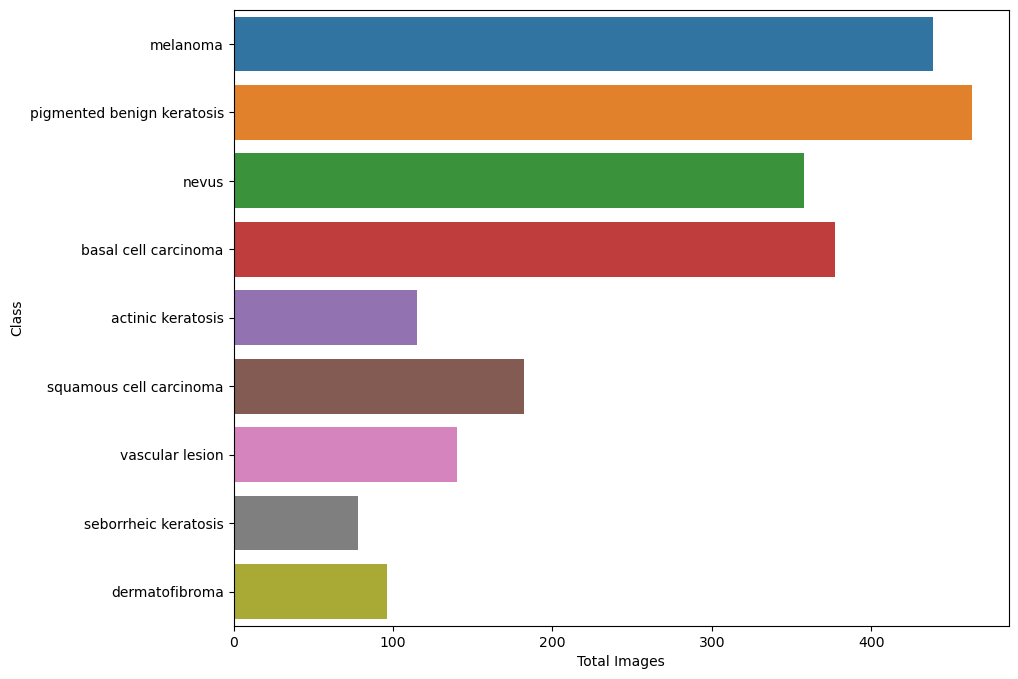

In [192]:
# Visualize data distribution by class
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="Total Images", y="Class", data=df,
            label="Class")

#### - Which class has the least number of samples?
- Seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis dominate the data in terms proportionate number of samples

#### Using the Augmentor to address class imbalance

In [145]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [147]:
path_to_training_dataset = pathlib.Path('CNN_Assignment/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x169156710>: 100%|█████████████████████████████████████████| 500/500 [00:02<00:00, 183.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16919FA90>: 100%|███████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 191.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x169090F10>: 100%|█████████████████████████████████████████| 500/500 [00:02<00:00, 171.58 Samples/s]


Initialised with 438 image(s) found.
Output directory set to CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x16902D550>: 100%|████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to CNN_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x1690F0590>: 100%|██████████████████████████████████████████| 500/500 [00:14<00:00, 34.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x168FC9B90>: 100%|███████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 161.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16903DD10>: 100%|███████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 69.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16905E790>: 100%|███████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1690A4990>: 100%|███████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 152.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [148]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [150]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0010407.jpg_8b3b203c-1ec9-42b5-84ec-8aa0e226ae93.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0010778.jpg_bafd6000-ad72-41fd-8bda-1a4cfca26519.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0000151.jpg_00cc6629-1424-408d-933a-b85e1d0dd9e5.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0000531.jpg_ac56c4a9-6a75-4d27-91d8-42de63d90b15.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0001157.jpg_d322551c-6a8e-4cce-a208-3e7ee691fa94.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0010995.jpg_8b0bbf45-bff2-4591-b123-e9bb5328003b.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0010564.jpg_37c4ebd7-e601-404f-b2bc-69662ae9fa88.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_0010912.jpg_e332a018-cf63-4cd2-98f1-eab8b56e918c.jpg',
 'CNN_Assignment/Train/melanoma/output/melanoma_original_ISIC_00

In [151]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [153]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [155]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

/var/folders/5v/kkcs3tkn3h131028yhzvlxy40000gq/T/ipykernel_61348/2621963877.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(df2)


In [156]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [157]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [175]:
data_dir_train="CNN_Assignment/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [176]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the module include normalization

In [177]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [178]:
from tensorflow.keras.layers import BatchNormalization

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))


model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model

In [179]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [180]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [181]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.2276 - loss: 2.0644
Epoch 1: val_accuracy improved from -inf to 0.42168, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 110s 643ms/step - accuracy: 0.2280 - loss: 2.0632 - val_accuracy: 0.4217 - val_loss: 1.5184
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.4226 - loss: 1.5486
Epoch 2: val_accuracy improved from 0.42168 to 0.47290, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 108s 637ms/step - accuracy: 0.4227 - loss: 1.5483 - val_accuracy: 0.4729 - val_loss: 1.3961
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.4987 - loss: 1.3670
Epoch 3: val_accuracy improved from 0.47290 to 0.54714, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 588ms/step - accuracy: 0.4987 - loss: 1.3668 - val_accuracy: 0.5471 - val_loss: 1.2247
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5481 - loss: 1.2167
Epoch 4: val_accuracy did not improv

### Visualize the model results

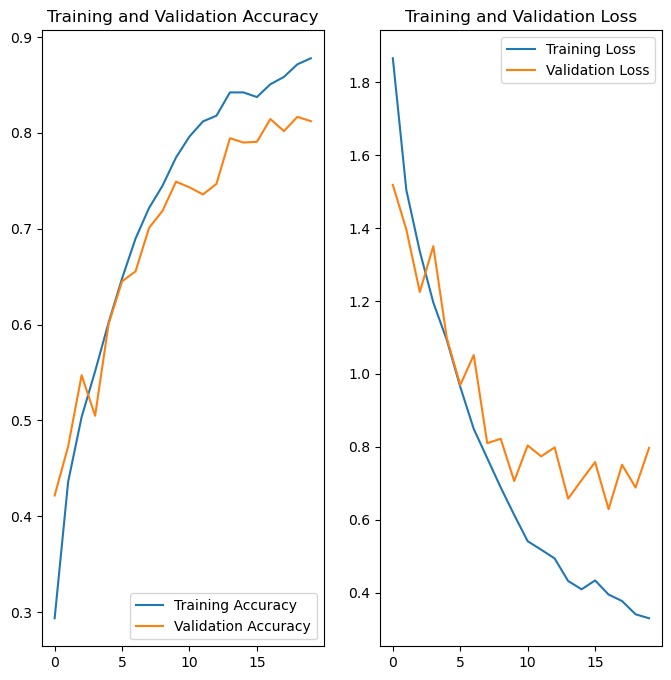

In [183]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyze your results here. 
#### Did you get rid of underfitting/overfitting? 
- Yes
#### Did class rebalance help?
- Yes



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


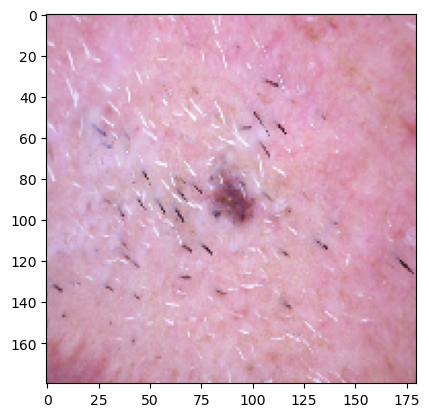

In [184]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )